**Load Necessary Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler,OneHotEncoder
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score,
    adjusted_rand_score, normalized_mutual_info_score,
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


**Load the Datasets**

In [3]:
# Load datasets
employee_df = pd.read_csv("/content/employee_data.csv")
insurance_df = pd.read_csv("/content/insurance_data.csv")
vendor_df = pd.read_csv("/content/vendor_data.csv")


**Perform Feature Engineering**

In [4]:
# Merge datasets
insurance_df = insurance_df.merge(employee_df, on="AGENT_ID", how="left")
insurance_df = insurance_df.merge(vendor_df, on="VENDOR_ID", how="left")

# Convert date columns
date_cols = ['REPORT_DT', 'LOSS_DT', 'TXN_DATE_TIME', 'POLICY_EFF_DT']
for col in date_cols:
    insurance_df[col] = pd.to_datetime(insurance_df[col], dayfirst=True, errors='coerce')

# Feature Engineering
insurance_df['CLAIM_TO_PREMIUM_RATIO'] = insurance_df['CLAIM_AMOUNT'] / (insurance_df['PREMIUM_AMOUNT'] + 1)
insurance_df['REPORT_DELAY'] = (insurance_df['REPORT_DT'] - insurance_df['LOSS_DT']).dt.days
insurance_df['POLICY_DURATION'] = (insurance_df['TXN_DATE_TIME'] - insurance_df['POLICY_EFF_DT']).dt.days
insurance_df['POLICY_COUNT_PER_CUSTOMER'] = insurance_df.groupby('CUSTOMER_ID')['POLICY_NUMBER'].transform('count')

# Categorical and Numerical Features
categorical_cols = ['INSURANCE_TYPE', 'MARITAL_STATUS', 'EMPLOYMENT_STATUS', 'HOUSE_TYPE', 'SOCIAL_CLASS']
numerical_cols = [
    'PREMIUM_AMOUNT', 'CLAIM_AMOUNT', 'AGE', 'TENURE', 'CLAIM_TO_PREMIUM_RATIO',
    'REPORT_DELAY', 'POLICY_DURATION', 'POLICY_COUNT_PER_CUSTOMER'
]

**Perform Preprocessing**

In [5]:
# Handle Missing Values
insurance_df.fillna(insurance_df.median(numeric_only=True), inplace=True)

# Encode Categorical Variables Using One-Hot Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)


In [9]:
pip install kneed

**Find Epsilon Optimally using Elbow Method**

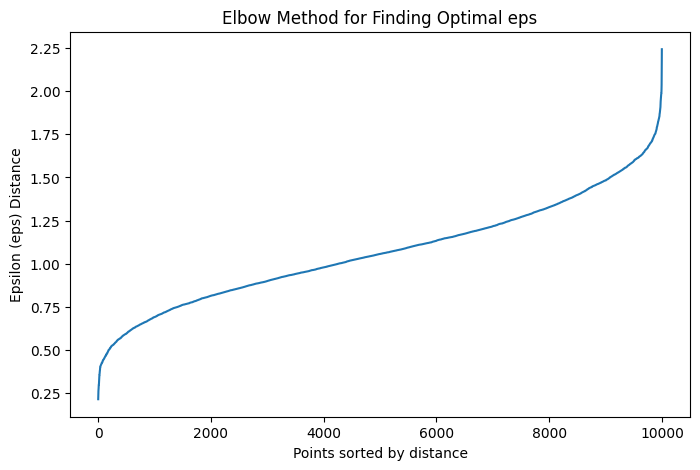

🔹 Automatically Selected Optimal Epsilon: 1.7695360557029647


In [32]:
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Reduce Dimensionality Using PCA (Keep 95% Variance)
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_reduced = pca.fit_transform(X_transformed)

# Apply Nearest Neighbors on Reduced Data
neigh = NearestNeighbors(n_neighbors=3)  # 4 because min_samples = 3+1
nbrs = neigh.fit(X_reduced)
distances, indices = nbrs.kneighbors(X_reduced)

# Sort distances and plot Elbow Curve
distances = np.sort(distances[:, 2])  # 3rd neighbor distance
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel("Epsilon (eps) Distance")
plt.title("Elbow Method for Finding Optimal eps")
plt.show()

# 📌 Automatically Find Optimal eps (Elbow Point Detection)
from kneed import KneeLocator

knee_locator = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
optimal_eps = distances[knee_locator.knee]

print(f"🔹 Automatically Selected Optimal Epsilon: {optimal_eps}")



**DBSCAN Model Training**

In [33]:
# 📌 Apply DBSCAN with Optimal eps
dbscan = DBSCAN(eps=optimal_eps, min_samples=5)
insurance_df['DBSCAN_Cluster'] = dbscan.fit_predict(X_transformed)

# Show Cluster Distribution
print("DBSCAN Cluster Distribution:\n", insurance_df['DBSCAN_Cluster'].value_counts())

DBSCAN Cluster Distribution:
 DBSCAN_Cluster
 0    9627
-1     362
 1       6
 2       5
Name: count, dtype: int64


**Model Evaluation**

In [20]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 📌 Unsupervised Clustering Metrics
dbscan_labels = insurance_df['DBSCAN_Cluster']
valid_clusters = [label for label in dbscan_labels.unique() if label != -1]  # Ignore Noise (-1)

if len(valid_clusters) >= 2:
    print("\n📌 Clustering Evaluation Metrics:")
    print(f"🔹 Silhouette Score: {silhouette_score(X_transformed, dbscan_labels):.4f}")
    print(f"🔹 Davies-Bouldin Score: {davies_bouldin_score(X_transformed, dbscan_labels):.4f}")
    print(f"🔹 Calinski-Harabasz Score: {calinski_harabasz_score(X_transformed, dbscan_labels):.4f}")
else:
    print("\n⚠️ DBSCAN resulted in only one cluster or noise. Adjust `eps` or `min_samples`.")



📌 Clustering Evaluation Metrics:
🔹 Silhouette Score: 0.1662
🔹 Davies-Bouldin Score: 2.0632
🔹 Calinski-Harabasz Score: 95.2025


**Model Testing - Negative Case**

In [29]:
import pandas as pd
import numpy as np

# Sample new transaction for testing
new_transaction = {
    "PREMIUM_AMOUNT": 61.45,
    "CLAIM_AMOUNT": 92000,
    "AGE": 59,
    "TENURE": 14,
    "CLAIM_TO_PREMIUM_RATIO": 1473.178543,
    "REPORT_DELAY": 15,
    "POLICY_DURATION": 429,
    "POLICY_COUNT_PER_CUSTOMER": 1,
    "INSURANCE_TYPE": "Life",
    "MARITAL_STATUS": "N",
    "EMPLOYMENT_STATUS": "Y",
    "HOUSE_TYPE": "Mortgage",
    "SOCIAL_CLASS": "MI"
}

# Convert the new transaction to DataFrame
new_df = pd.DataFrame([new_transaction])

# Ensure the new transaction has the same columns as the original dataset
new_df = new_df[numerical_cols + categorical_cols]

# Apply the same preprocessing (scaling and encoding) to the new transaction
new_scaled = preprocessor.transform(new_df)

# Apply the PCA transformation (use the already fitted PCA model)
new_reduced = pca.transform(new_scaled)

# Predict cluster using Nearest Neighbors (find the closest point)
_, nearest_index = nbrs.kneighbors(new_reduced)
new_cluster = dbscan.labels_[nearest_index[0][0]]  # Assign the nearest cluster

# Define anomaly clusters (e.g., -1, 1, 2 based on your output)
anomaly_clusters = {-1, 1, 2}

# Classify the transaction as normal or anomalous
if new_cluster in anomaly_clusters:
    print(f"🚨 ALERT: The transaction is ANOMALOUS! (Cluster {new_cluster})")
else:
    print(f"✅ The transaction is NORMAL (Cluster {new_cluster})")


🚨 ALERT: The transaction is ANOMALOUS! (Cluster -1)


**Model Testing - Positive Case**

In [30]:
import pandas as pd
import numpy as np

# Sample new transaction for testing
new_transaction = {
    "PREMIUM_AMOUNT": 12.45,
    "CLAIM_AMOUNT": 9200,
    "AGE": 39,
    "TENURE": 14,
    "CLAIM_TO_PREMIUM_RATIO": 1473.1543,
    "REPORT_DELAY": 25,
    "POLICY_DURATION": 479,
    "POLICY_COUNT_PER_CUSTOMER": 2,
    "INSURANCE_TYPE": "Life",
    "MARITAL_STATUS": "N",
    "EMPLOYMENT_STATUS": "Y",
    "HOUSE_TYPE": "Mortgage",
    "SOCIAL_CLASS": "MI"
}

# Convert the new transaction to DataFrame
new_df = pd.DataFrame([new_transaction])

# Ensure the new transaction has the same columns as the original dataset
new_df = new_df[numerical_cols + categorical_cols]

# Apply the same preprocessing (scaling and encoding) to the new transaction
new_scaled = preprocessor.transform(new_df)

# Apply the PCA transformation (use the already fitted PCA model)
new_reduced = pca.transform(new_scaled)

# Predict cluster using Nearest Neighbors (find the closest point)
_, nearest_index = nbrs.kneighbors(new_reduced)
new_cluster = dbscan.labels_[nearest_index[0][0]]  # Assign the nearest cluster

# Define anomaly clusters (e.g., -1, 1, 2 based on your output)
anomaly_clusters = {-1, 1, 2}

# Classify the transaction as normal or anomalous
if new_cluster in anomaly_clusters:
    print(f"🚨 ALERT: The transaction is ANOMALOUS! (Cluster {new_cluster})")
else:
    print(f"✅ The transaction is NORMAL (Cluster {new_cluster})")


✅ The transaction is NORMAL (Cluster 0)


**Analysing Feature Importance**

In [25]:
import numpy as np
import pandas as pd

# Get feature names after encoding (numerical + one-hot categorical features)
encoded_feature_names = (
    numerical_cols +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
)

# Get absolute loadings (importance) of each feature in the first few principal components
pca_importance = np.abs(pca.components_[:2])  # First 2 components
pca_feature_importance = np.mean(pca_importance, axis=0)  # Mean importance per feature

# Create DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': encoded_feature_names,
    'Importance': pca_feature_importance
}).sort_values(by='Importance', ascending=False)

# Display top contributing features
print("🔹 Features contributing most to PCA-reduced clustering:")
print(importance_df.head(10))


🔹 Features contributing most to PCA-reduced clustering:
                    Feature  Importance
0            PREMIUM_AMOUNT    0.477158
4    CLAIM_TO_PREMIUM_RATIO    0.395411
1              CLAIM_AMOUNT    0.371662
10    INSURANCE_TYPE_Mobile    0.168323
9       INSURANCE_TYPE_Life    0.136398
8     INSURANCE_TYPE_Health    0.119780
12  INSURANCE_TYPE_Property    0.065416
13    INSURANCE_TYPE_Travel    0.055470
11     INSURANCE_TYPE_Motor    0.053182
2                       AGE    0.043226


In [26]:
# Filter transactions labeled as anomalies (DBSCAN cluster = -1)
anomalies = insurance_df[insurance_df['DBSCAN_Cluster'] == -1]

# Display 5 sample anomaly transactions
print(anomalies.head(5))


   TXN_DATE_TIME TRANSACTION_ID CUSTOMER_ID POLICY_NUMBER POLICY_EFF_DT  \
10    2020-06-01    TXN00000011   A00007952   PLC00003007    2019-03-30   
13    2020-06-01    TXN00000014   A00007988   PLC00002521    2020-01-29   
53    2020-06-02    TXN00000054   A00000859   PLC00008827    2017-09-05   
62    2020-06-02    TXN00000063   A00002702   PLC00003400    2017-05-21   
65    2020-06-02    TXN00000066   A00000261   PLC00006979    2011-02-17   

      LOSS_DT  REPORT_DT INSURANCE_TYPE  PREMIUM_AMOUNT  CLAIM_AMOUNT  ...  \
10 2020-05-20 2020-05-25           Life           61.45         92000  ...   
13 2020-05-18 2020-05-23           Life           64.16         51000  ...   
53 2020-05-27 2020-05-29       Property          104.05         16000  ...   
62 2020-05-24 2020-05-27       Property          151.81         15000  ...   
65 2020-05-26 2020-05-28           Life           67.55         96000  ...   

          ADDRESS_LINE1 ADDRESS_LINE2      CITY STATE POSTAL_CODE  \
10  4255 Ta

**Saving Model and Preprocessor as Pickle**

In [31]:
import pickle

# Save DBSCAN model
with open("dbscan_model.pkl", "wb") as model_file:
    pickle.dump(dbscan, model_file)

# Save Preprocessor (StandardScaler + OneHotEncoder)
with open("preprocessor.pkl", "wb") as preprocessor_file:
    pickle.dump(preprocessor, preprocessor_file)

print("✅ Model and Preprocessor saved successfully!")


✅ Model and Preprocessor saved successfully!
